In [16]:
#!git clone https://github.com/opendatacube/datacube-core
#!cd datacube-core
!python setup.py install

python: can't open file 'setup.py': [Errno 2] No such file or directory


In [10]:
import numpy as np
import geopandas as gp
import pandas as pd
from rasterio.plot import show
import rasterio as rio
import rasterio.features
import rasterio.warp
import earthpy.spatial as es
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pickle
from ipypb import track
import traceback
from collections.abc import Iterable

import rioxarray as xrio
import xarray as xr
import xshape as xs
from dea_spatialtools import xr_rasterize

import imageio
from ipypb import track
from IPython.display import Image
from scipy import spatial

# from hlp import browse_site
# import hlp

ModuleNotFoundError: No module named 'dea_spatialtools'

In [8]:
browse_site(sites,'1119USBR_WQX-AFE035')

### Read in list of sites for download and setup metadata

In [5]:
os.chdir("E:/University College London/O'Sullivan, Aidan - SDG6/")

sites = pd.read_pickle("sites4.p")
#sites = sites.set_index(['sid','dt'])
sites = sites.set_geometry('geometry_poly')
#sites = sites.drop(columns=['monitoringSiteIdentifier','wbid','thematicId'])

### Xarray construction

In [6]:
os.chdir("E:/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Corrected data V2")

## list of files to process
dl_files = os.listdir()

## list of files already processed
#pixel_files = os.listdir("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Test/")

#for sid in track(pl.index.get_level_values(0).unique()):

sid = 'ATSE40101000'
    
sid_files = [ i for i in dl_files if sid in i ]

eids = list(set([ i.split('__')[1][0:40] for i in sid_files ]))

eid = eids[4]

sid_eid_files = [ i for i in sid_files if eid in i ]


In [7]:
## get CRS of raster
with rio.open(sid_eid_files[0]) as src:            

    ras_crs = src.crs

src.close()

## read in first tif in list
xtif = xrio.open_rasterio(sid_eid_files[0],
                          masked=True,
                         default_name=sid_eid_files[0].split('__')[1][41:47].split('_')[0].replace('.',''))
      
xtif = xtif[0]

## add other tifs in a loop
# for adtif in sid_eid_files[1:len(sid_eid_files)]:
    
#     ## read in subsequent tifs and merge
#     ytif = xrio.open_rasterio(adtif,
#                               masked=True,
#                               default_name=adtif.split('__')[1][41:47].split('_')[0].replace('.',''))
             
#     ytif = ytif[0]
#     xtif = xr.merge([xtif,ytif],compat='override')
 
    
## retrieve monitoring location as point
pt = sites.loc[sid,:].set_geometry('geometry_ll')[0:1]             

## change crs of pt
original_crs = sites.crs
pt = pt.to_crs(ras_crs)

## change crs of poly
poly = pt.set_geometry('geometry_poly')
poly.crs = original_crs
poly = poly.to_crs(ras_crs) 
    
# ## Add polygon and point to xarray
# xpt = xr.DataArray(1, coords=[pt.geometry.values.y, 
#                               pt.geometry.values.x], 
#                    dims=['y', 'x'],
#                    name='monitor_pt')

# xtif = xr.merge([xtif,xpt],compat='override')

## Add attributes to combined xarray from last tif
# xtif.attrs = {key: ytif.attrs[key] for key in ytif.attrs.keys() & {'transform', 'scale_factor','add_offset','grid_mapping'}}
# xtif.attrs['shape'] = xtif['B2'].shape
xtif.attrs['crs'] = str(src.crs)
xtif.attrs['eid'] = sid_eid_files[0].split('__')[1][0:40]
xtif.attrs['sid'] = sid_eid_files[0].split('__')[0]

xtif = xtif.load().drop(['band','spatial_ref'])

#### Create mask as xarray object

In [12]:
xtif.geobox

AttributeError: 'DataArray' object has no attribute 'geobox'

In [8]:
## set buffer distance

buff = 75

## Create mask
ShapeMask = rasterio.features.geometry_mask(poly.buffer(-buff).geometry,
                                      out_shape=(len(xtif.y), len(xtif.x)),
                                      transform=xtif.geobox.transform,
                                      invert=True)

ShapeMask = xr.DataArray(ShapeMask, dims=("y", "x"))

## Then apply the mask
xtif_masked = xtif.where(ShapeMask == True, drop=True)

AttributeError: 'DataArray' object has no attribute 'geobox'

### Pixel selection using euclidean distance

In [7]:
#def select_pixels(array,point,n,max_dis)

## create coordinate list from array
coords = xtif_masked.to_dataframe().dropna().reset_index()[['x', 'y']].values

x = coords[:,0]
y = coords[:,1]

In [8]:
## set number of pixels to select
k = 9
max_dis = 500

## set point as tuple
ptxy = (pt.geometry.x.values[0],pt.geometry.y.values[0])

## calculate distance between point xy and grid xy
x_dist = np.abs(x - ptxy[0])
y_dist = np.abs(y - ptxy[1])

## calculate euclidean distance
euc_dist = np.sqrt(x_dist**2 + y_dist**2)

## return max distance based on
max_neighbour_dist = sorted(euc_dist)[k]

if max_neighbour_dist<max_dis:
    max_neighbour_dist = max_neighbour_dist
else:
    max_neighbour_dist = 0

neighbours_x = x[euc_dist<max_neighbour_dist]
neighbours_y = y[euc_dist<max_neighbour_dist]

print(f'Number of coordinates returned: {len(neighbours_y)} \nDistance to furthest pixel {round(max_neighbour_dist,0)}')

Number of coordinates returned: 9 
Distance to furthest pixel 54.0


### Creating mask

In [142]:
x = xtif_masked.x.values
y = xtif_masked.y.values

xm, ym = np.meshgrid(x,y)

ymbools = np.isin(ym,neighbours_y)
xmbools = np.isin(xm,neighbours_x)

mbools = ymbools*xmbools


In [143]:
pixel_mask = xr.DataArray(mbools, dims=('y','x'))

## Then apply the mask
pixels = xtif_masked.where(pixel_mask == True, drop=True)

(5293620.0, 5312160.0)

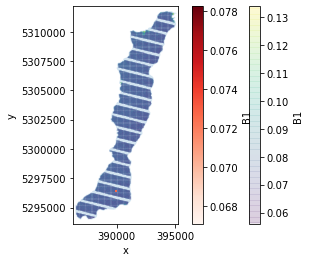

In [160]:
fig, ax = plt.subplots()


xtif_masked.plot(ax=ax,alpha=0.1)
poly.plot(ax=ax,alpha=0.2)
pixels.plot(ax=ax,cmap='Reds')


ax.set_xlim(xtif.x.values.min(), xtif.x.values.max()) 
ax.set_ylim(xtif.y.values.min(), xtif.y.values.max())


### Vectorized indexing

In [167]:
yind = xr.DataArray([507,507],dims=['y'])
xind = xr.DataArray([111,112],dims=['y'])

In [166]:
xtif_masked[[507,507], [111,112]].values

array([[0.07266229, 0.07823171],
       [0.07266229, 0.07823171]])

In [168]:
xtif_masked[yind, xind].values

array([0.07266229, 0.07823171])

In [180]:
neigh_xind = [ np.where(xtif_masked.x.values==i)[0][0] for i in neighbours_x ]
neigh_yind =[ np.where(xtif_masked.y.values==i)[0][0] for i in neighbours_y ]

ind_x = xr.DataArray(neigh_xind, dims=['y'])

ind_y = xr.DataArray(neigh_yind, dims=['y'])


ind = xr.DataArray(neigh_xind, dims='y'), \
       xr.DataArray(neigh_yind, dims='x')

In [197]:
test = xtif_masked.isel(x=ind_x,y=ind_y)
test2 = test.set_index(y='y',x='x')

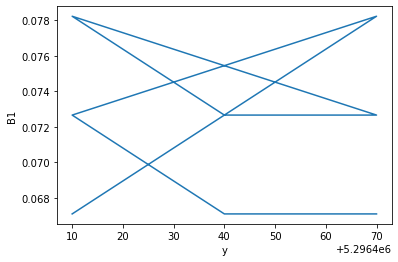

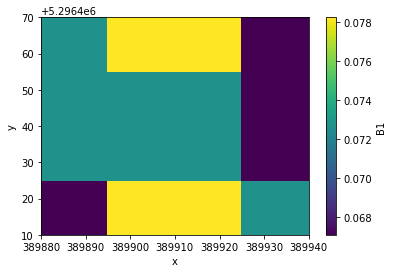

In [170]:
pixel1 = xtif_masked[ind_y,ind_x]
pixel2 = xtif_masked.sel(x=neighbours_x,y=neighbours_y)

pixel1.sortby(['x','y']).plot()
plt.show()
pixel2.sortby(['x','y']).plot()

### Indexing on coord pairs

In [225]:
tifdf = xtif_masked.to_dataframe().reset_index()

neighbours = list(zip(neighbours_x,neighbours_y))
coords = list(zip(tifdf.x,tifdf.y))

In [70]:
neighbours_idx = [ i in neighbours for i in coords ]
neighbours_idxa = np.array(neighbours_idx).reshape(xtif.shape)

In [112]:
index = np.arange(len(neighbours_idx))

In [113]:
index = index[neighbours_idxa]

In [114]:
xindex = xr.DataArray(index, dims=['x'])
yindex = xr.DataArray(index, dims=['y'])

In [140]:
xtif[xindex,xindex]

NameError: name 'xindex' is not defined

In [90]:
testidx = xr.DataArray(neighbours_idxa[0], dims='x')

In [72]:
# return DataArray indexers
ind = xr.DataArray(neighbours_x, dims='x'), \
       xr.DataArray(neighbours_x, dims='y')

ValueError: different number of dimensions on data and dims: 2 vs 1

### Plotting results

0.33357957005500793
0.2848019301891327
0.33646661043167114
0.2763057053089142
0.35761091113090515
0.26305273175239563
0.19524797797203064
0.36338505148887634
0.2723463177680969


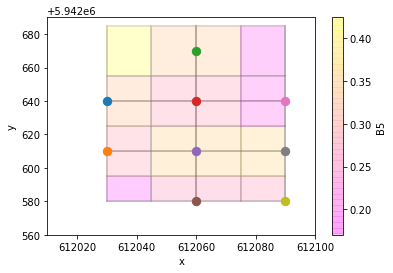

In [84]:
fig, ax = plt.subplots()
pixels.sortby(['x','y'])['B5'].plot.pcolormesh('x','y',cmap='spring',ax=ax,alpha=0.2,edgecolors='grey')
plt.xlim(neighbours_x.min()-20,neighbours_x.max()+10)
plt.ylim(neighbours_y.min()-20,neighbours_y.max()+20)

for i in range(k):

    temp = xtif.sel(x=neighbours_x[i],y=neighbours_y[i])
    print(temp['B5'].values)
    
    plt.scatter(neighbours_x[i],neighbours_y[i],s=70)


plt.show()

(5293320.0, 5312460.0)

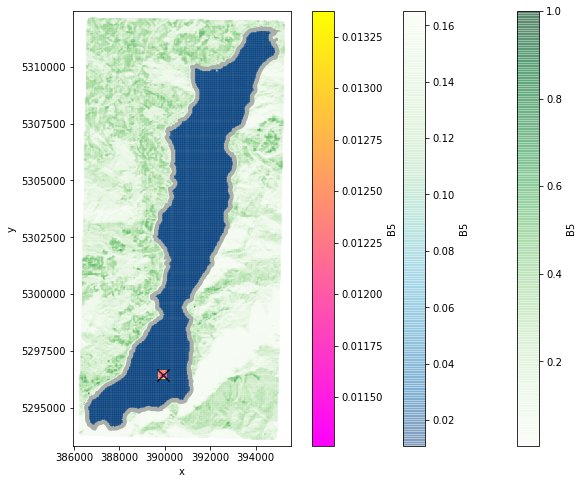

In [159]:
fig, ax = plt.subplots(figsize=(12,8))


xtif['B5'].plot(alpha=0.4,ax=ax,cmap='Greens')
poly.plot(ax=ax,alpha=0.3,color='k')
xtif_masked['B5'].plot(alpha=0.3,ax=ax,cmap='GnBu_r')
pixels.sortby(['x','y'])['B5'].plot(cmap='spring',ax=ax)
pt.plot(ax=ax,color='k',marker="x",markersize=150,alpha=0.8)

bord = 300
ax.set_xlim(xtif.x.values.min()-bord, xtif.x.values.max()+bord) 
ax.set_ylim(xtif.y.values.min()-bord, xtif.y.values.max()+bord)

### Extracting values

In [145]:
pdf = np.mean(pixels,axis=0).to_dataframe()

In [146]:
pdff = pdf.reset_index().drop_duplicates()
print(len(pdff))
pdff

9


,x,B1,B2,B3,B4,B5,B6,cirrus,cloud,band,spatial_ref,eid,sid
0,0,0.056007,0.048118,0.047322,0.061462,0.011852,287.524780,3.0,1.0,1,0,LE07_L1TP_192013_20150817_20161022_01_T1,SE742829-183168
1,1,0.056007,0.048118,0.047322,0.061462,0.011852,287.524780,3.0,1.0,1,0,LE07_L1TP_192013_20150817_20161022_01_T1,SE742829-183168
2,2,0.056007,0.048118,0.047322,0.061462,0.011852,287.524780,3.0,1.0,1,0,LE07_L1TP_192013_20150817_20161022_01_T1,SE742829-183168
3,3,0.056007,0.048118,0.047322,0.061462,0.011852,287.524780,3.0,1.0,1,0,LE07_L1TP_192013_20150817_20161022_01_T1,SE742829-183168
4,4,0.049530,0.044566,0.042384,0.044349,0.004407,287.218926,3.0,1.0,1,0,LE07_L1TP_192013_20150817_20161022_01_T1,SE742829-183168
5,5,0.049530,0.044566,0.042384,0.044349,0.004407,287.218926,3.0,1.0,1,0,LE07_L1TP_192013_20150817_20161022_01_T1,SE742829-183168
6,6,0.049530,0.044566,0.042384,0.044349,0.004407,287.218926,3.0,1.0,1,0,LE07_L1TP_192013_20150817_20161022_01_T1,SE742829-183168
7,7,0.051554,0.043233,0.047322,0.046250,0.009561,287.218926,3.0,1.0,1,0,LE07_L1TP_192013_20150817_20161022_01_T1,SE742829-183168
8,8,0.051554,0.043233,0.047322,0.046250,0.009561,287.218926,3.0,1.0,1,0,LE07_L1TP_192013_20150817_20161022_01_T1,SE742829-183168


In [393]:
from rasterio.warp import transform
import numpy as np

url = adtif
da = xr.open_rasterio(url)

# Compute the lon/lat coordinates with rasterio.warp.transform
ny, nx = len(da['y']), len(da['x'])
x, y = np.meshgrid(da['x'], da['y'])

# Rasterio works with 1D arrays
lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
                     x.flatten(), y.flatten())
lon = np.asarray(lon).reshape((ny, nx))
lat = np.asarray(lat).reshape((ny, nx))
da.coords['lon'] = (('y', 'x'), lon)
da.coords['lat'] = (('y', 'x'), lat)

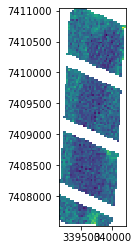

(1, 117, 36)


In [166]:
with rio.open(sid_eid_files[0]) as src:
    data = src.read()
    show(src)
    
    print(data.shape)

In [148]:
polygons = sites[sites.source=='EEA'].reset_index()[['sid','geometry_poly']].drop_duplicates()